In [1]:
# MODULE 1: SETUP & INGESTION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Sklearn Imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, 
                             auc, recall_score, f1_score)
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# Cấu hình
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# 1. Đọc & Làm sạch dữ liệu
file_path = 'transactions_feature_engineered.csv'
df = pd.read_csv(file_path, sep=';')

print(f"Kích thước ban đầu: {df.shape}")
df.dropna(inplace=True)
print(f"Kích thước sau khi dropna: {df.shape}")

# Xóa cột ID không dùng cho training
cols_to_drop = ['transaction_id', 'user_id']
# Chỉ drop nếu cột tồn tại
df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)

Kích thước ban đầu: (299695, 42)
Kích thước sau khi dropna: (299695, 42)


In [2]:
# MODULE 2: FEATURE ENGINEERING

# 1. Security Score (Tổng điểm bảo mật)
security_cols = ['avs_match', 'cvv_result', 'three_ds_flag']
# Kiểm tra xem các cột này có tồn tại không trước khi cộng
available_sec_cols = [c for c in security_cols if c in df.columns]
if available_sec_cols:
    df['security_score'] = df[available_sec_cols].sum(axis=1)
    print(f"- Đã tạo: 'security_score' từ {available_sec_cols}")
else:
    print("- Cảnh báo: Không tìm thấy cột bảo mật để tạo 'security_score'")

# 2. Spending Behavior (Hành vi tiêu dùng)
if 'avg_amount_user' in df.columns and 'amount' in df.columns:
    df['amount_ratio'] = np.where(df['avg_amount_user'] > 0, 
                                  df['amount'] / df['avg_amount_user'], 
                                  0)
    print("- Đã tạo: 'amount_ratio'")

# 3. Geolocation
# Logic: Tìm các mã quốc gia chung (VD: US, VN) và kiểm tra xem có khớp không
try:
    # Lấy danh sách mã quốc gia từ tên cột (VD: country_US -> US)
    country_codes = [c.replace('country_', '') for c in df.columns if c.startswith('country_')]
    bin_codes = [c.replace('bin_country_', '') for c in df.columns if c.startswith('bin_country_')]
    common_codes = set(country_codes).intersection(bin_codes)

    if common_codes:
        matches = pd.Series(0, index=df.index)
        for code in common_codes:
            # Nếu country_CODE == 1 VÀ bin_country_CODE == 1 thì là khớp (Match)
            c_col = f'country_{code}'
            b_col = f'bin_country_{code}'
            matches = matches | ((df[c_col] == 1) & (df[b_col] == 1))
        
        # Geo Mismatch là ngược lại của Match (1 - Match)
        df['geo_mismatch'] = 1 - matches.astype(int)
        print(f"- Đã tạo: 'geo_mismatch' (Dựa trên {len(common_codes)} mã quốc gia)")
    elif 'country' in df.columns and 'bin_country' in df.columns:
        # Fallback nếu còn cột gốc
        df['geo_mismatch'] = (df['country'] != df['bin_country']).astype(int)
        print("- Đã tạo: 'geo_mismatch' (Dựa trên cột gốc)")
    else:
        print("- Bỏ qua: 'geo_mismatch' (Không tìm thấy thông tin quốc gia)")
except Exception as e:
    print(f"- Lỗi khi tạo geo_mismatch: {e}")

# 4. Logistics & Anomalies
# Weird Grocery Ship
if 'merchant_category' in df.columns:
    df['weird_grocery_ship'] = ((df['merchant_category'] == 'grocery') & (df['shipping_distance_km'] > 500)).astype(int)
    print("- Đã tạo: 'weird_grocery_ship' (Cột gốc)")
elif 'merchant_category_grocery' in df.columns:
    df['weird_grocery_ship'] = ((df['merchant_category_grocery'] == 1) & (df['shipping_distance_km'] > 500)).astype(int)
    print("- Đã tạo: 'weird_grocery_ship' (Cột One-Hot)")

# Distance per Dollar
if 'shipping_distance_km' in df.columns and 'amount' in df.columns:
    df['distance_per_dollar'] = df['shipping_distance_km'] / (df['amount'] + 0.1)
    print("- Đã tạo: 'distance_per_dollar'")

# Đảm bảo target là số
if 'is_fraud' in df.columns:
    df['is_fraud'] = df['is_fraud'].astype(int)

# --- IN MẪU DỮ LIỆU AN TOÀN ---
print("\nXem mẫu dữ liệu các cột mới tạo:")
cols_to_show = [c for c in ['security_score', 'amount_ratio', 'geo_mismatch', 'weird_grocery_ship'] if c in df.columns]
if cols_to_show:
    print(df[cols_to_show].head(3))
else:
    print("Không có cột mới nào được tạo.")

- Đã tạo: 'security_score' từ ['avs_match', 'cvv_result', 'three_ds_flag']
- Đã tạo: 'amount_ratio'
- Đã tạo: 'geo_mismatch' (Dựa trên 10 mã quốc gia)
- Đã tạo: 'weird_grocery_ship' (Cột One-Hot)
- Đã tạo: 'distance_per_dollar'

Xem mẫu dữ liệu các cột mới tạo:
   security_score  amount_ratio  geo_mismatch  weird_grocery_ship
0               3      0.572906             0                   0
1               0      0.729399             0                   0
2               3      0.624349             0                   0


=============== BẮT ĐẦU PHÂN TÍCH EDA ===============

0. Đang vẽ phân phối nhãn (Class Distribution)...


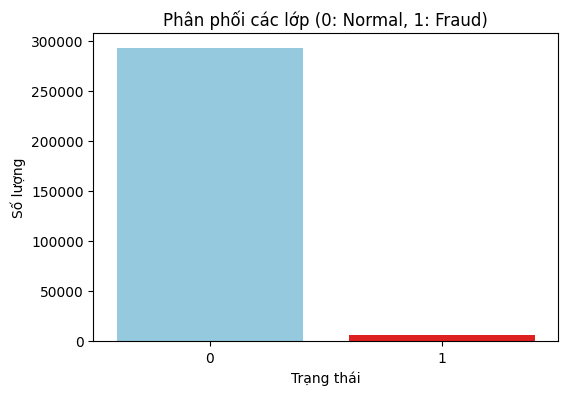

-> Số lượng Gian lận: 6612 / 299695
-> Tỷ lệ Gian lận: 2.21%

1. Đang vẽ biểu đồ theo khung giờ (Hourly)...


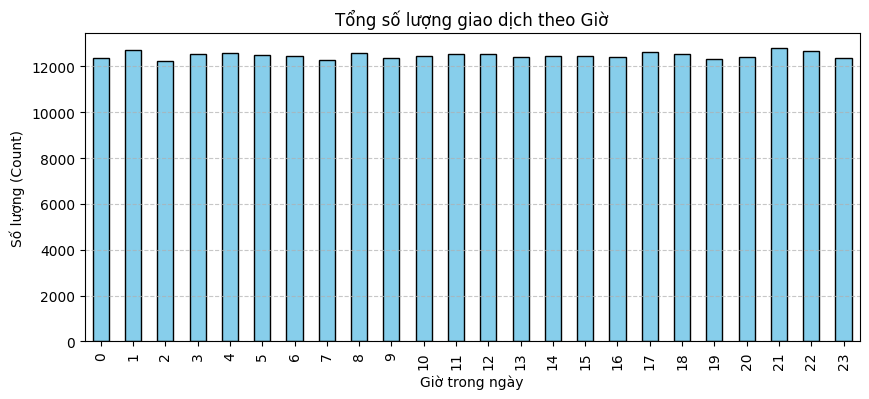

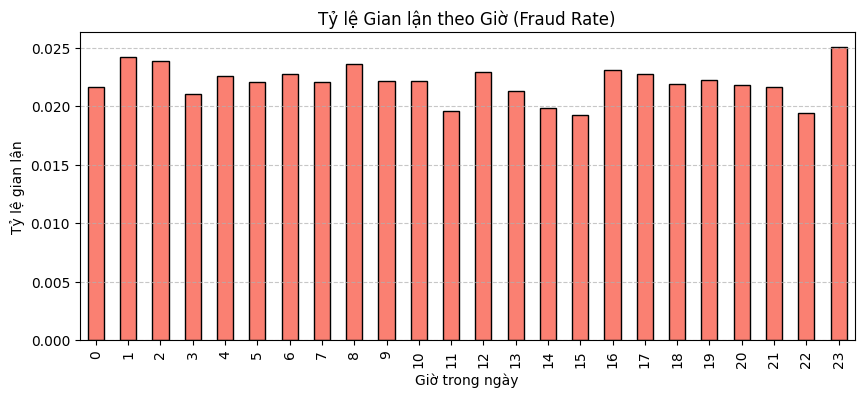

Top 5 khung giờ có tỷ lệ gian lận cao nhất:
hour
23    0.025071
1     0.024208
2     0.023928
8     0.023670
16    0.023121
Name: is_fraud, dtype: float64

2. Đang vẽ ma trận tương quan (Numeric Features)...


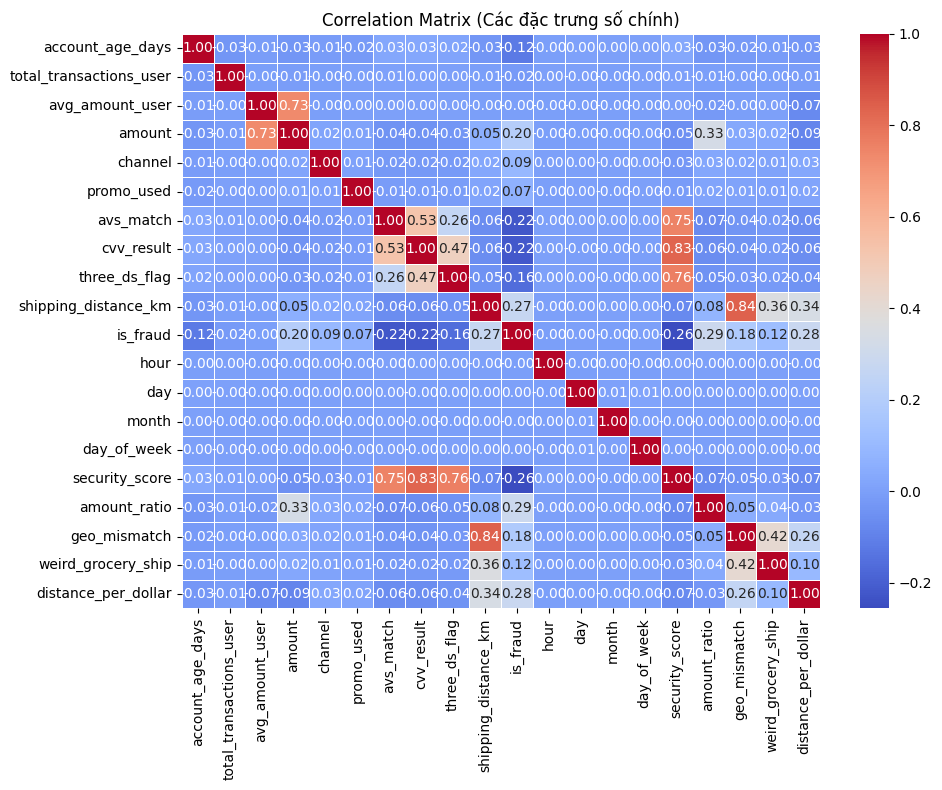

Top 10 đặc trưng tương quan mạnh nhất với 'is_fraud':
is_fraud                1.000000
amount_ratio            0.292384
distance_per_dollar     0.282846
shipping_distance_km    0.270004
security_score          0.255871
avs_match               0.223299
cvv_result              0.218982
amount                  0.202499
geo_mismatch            0.181083
three_ds_flag           0.162160
Name: is_fraud, dtype: float64

3. Đang vẽ biểu đồ theo Channel & Merchant Category...


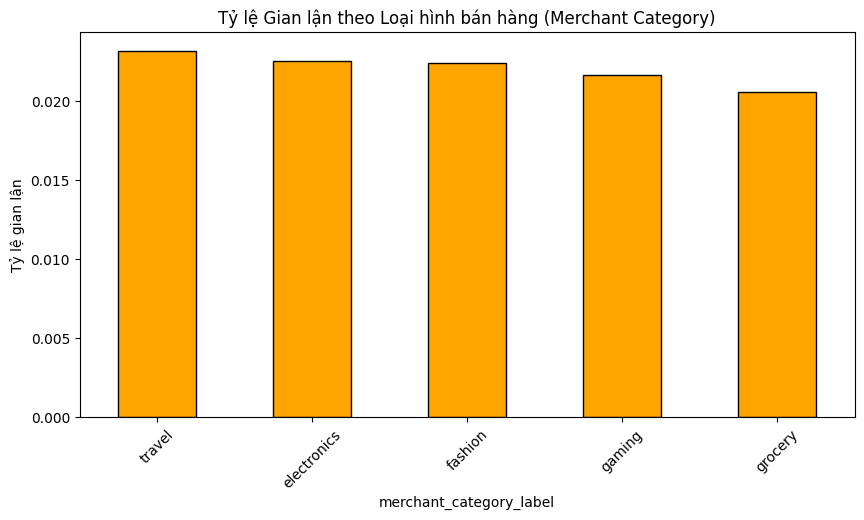

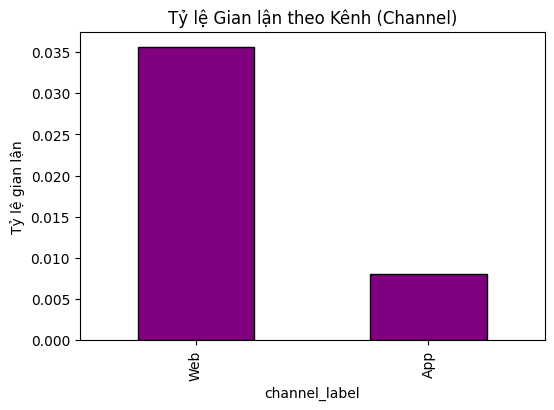


4. Đang vẽ phân phối số tiền giao dịch (Amount)...


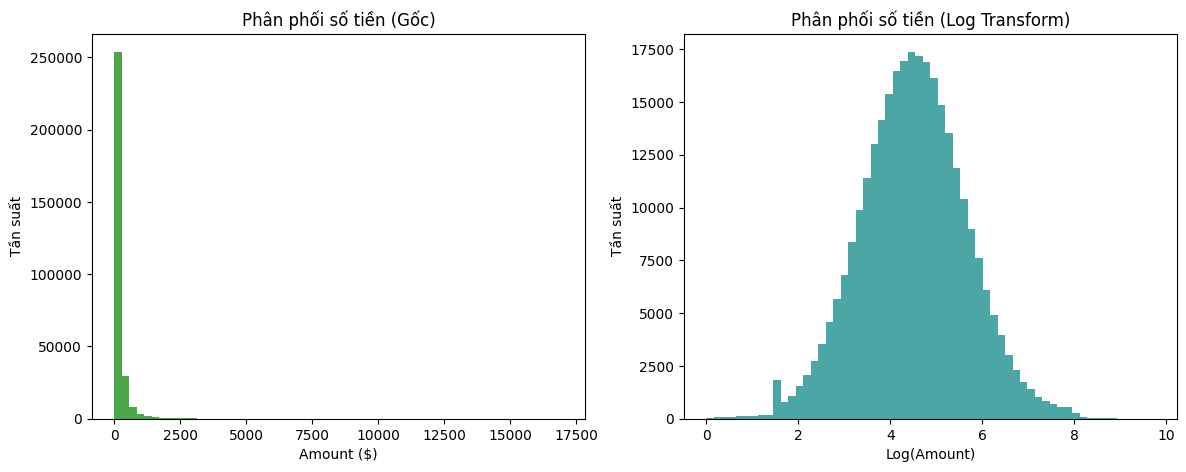

Thống kê số tiền:
{'amount_mean': 177.16527856654264, 'amount_std': 306.92650696278685}


In [ ]:
# --- MODULE 2.5: EXPLORATORY DATA ANALYSIS (EDA) ---

def run_eda_analysis(df):
    print(f"{'='*15} BẮT ĐẦU PHÂN TÍCH EDA {'='*15}")
    
    print("\n0. Đang vẽ phân phối nhãn (Class Distribution)...")
    plt.figure(figsize=(6, 4))
    sns.countplot(x='is_fraud', data=df, palette=['skyblue', 'red'])
    plt.title('Phân phối các lớp (0: Normal, 1: Fraud)')
    plt.xlabel('Trạng thái')
    plt.ylabel('Số lượng')
    plt.show()

    # Tính tỷ lệ cụ thể để in ra cho rõ
    fraud_count = df['is_fraud'].sum()
    total_count = len(df)
    print(f"-> Số lượng Gian lận: {fraud_count} / {total_count}")
    print(f"-> Tỷ lệ Gian lận: {fraud_count/total_count:.2%}")

    # 1. PHÂN TÍCH THEO GIỜ
    print("\n1. Đang vẽ biểu đồ theo khung giờ (Hourly)...")
    if 'hour' in df.columns:
        fraud_by_hour = df.groupby('hour')['is_fraud'].mean()
        tx_by_hour = df.groupby('hour')['is_fraud'].count()

        # Biểu đồ 1: Số lượng giao dịch
        plt.figure(figsize=(10, 4))
        tx_by_hour.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title('Tổng số lượng giao dịch theo Giờ')
        plt.ylabel('Số lượng (Count)')
        plt.xlabel('Giờ trong ngày')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

        # Biểu đồ 2: Tỷ lệ gian lận
        plt.figure(figsize=(10, 4))
        fraud_by_hour.plot(kind='bar', color='salmon', edgecolor='black')
        plt.title('Tỷ lệ Gian lận theo Giờ (Fraud Rate)')
        plt.ylabel('Tỷ lệ gian lận')
        plt.xlabel('Giờ trong ngày')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

        print("Top 5 khung giờ có tỷ lệ gian lận cao nhất:")
        print(fraud_by_hour.sort_values(ascending=False).head(5))
    else:
        print("Cảnh báo: Không tìm thấy cột 'hour'.")

    # 2. MA TRẬN TƯƠNG QUAN
    print("\n2. Đang vẽ ma trận tương quan (Numeric Features)...")
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cols_to_plot = [c for c in num_cols if 'merchant_' not in c and 'country_' not in c and 'id' not in c]
    
    if 'is_fraud' not in cols_to_plot and 'is_fraud' in df.columns: 
        cols_to_plot.append('is_fraud')
        
    corr = df[cols_to_plot].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix (Các đặc trưng số chính)')
    plt.tight_layout()
    plt.show()

    print("Top 10 đặc trưng tương quan mạnh nhất với 'is_fraud':")
    if 'is_fraud' in corr.columns:
        print(corr['is_fraud'].abs().sort_values(ascending=False).head(10))

    # 3. PHÂN TÍCH CHANNEL & CATEGORY
    print("\n3. Đang vẽ biểu đồ theo Channel & Merchant Category...")
    
    df_viz = df.copy()

    merch_cols = [c for c in df.columns if 'merchant_category_' in c]
    col_cat = None
    if merch_cols:
        df_viz['merchant_category_label'] = df_viz[merch_cols].idxmax(axis=1).apply(lambda x: x.replace('merchant_category_', ''))
        col_cat = 'merchant_category_label'
    elif 'merchant_category' in df.columns:
        col_cat = 'merchant_category'

    if col_cat:
        fraud_by_category = df_viz.groupby(col_cat)['is_fraud'].mean().sort_values(ascending=False)
        plt.figure(figsize=(10, 5))
        fraud_by_category.plot(kind='bar', color='orange', edgecolor='black')
        plt.title('Tỷ lệ Gian lận theo Loại hình bán hàng (Merchant Category)')
        plt.ylabel('Tỷ lệ gian lận')
        plt.xticks(rotation=45)
        plt.show()

    if 'channel' in df_viz.columns:
        if pd.api.types.is_numeric_dtype(df_viz['channel']):
             df_viz['channel_label'] = df_viz['channel'].map({1: 'Web', 0: 'App'})
        else:
             df_viz['channel_label'] = df_viz['channel']
        
        fraud_by_channel = df_viz.groupby('channel_label')['is_fraud'].mean().sort_values(ascending=False)
        plt.figure(figsize=(6, 4))
        fraud_by_channel.plot(kind='bar', color='purple', edgecolor='black')
        plt.title('Tỷ lệ Gian lận theo Kênh (Channel)')
        plt.ylabel('Tỷ lệ gian lận')
        plt.show()

    # 4. PHÂN TÍCH SỐ TIỀN
    print("\n4. Đang vẽ phân phối số tiền giao dịch (Amount)...")
    if 'amount' in df.columns:
        amount = df['amount'].astype(float)
        amount_pos = amount[amount > 0] 
        log_amount = np.log(amount_pos)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        ax1.hist(amount_pos, bins=60, color='green', alpha=0.7)
        ax1.set_title('Phân phối số tiền (Gốc)')
        ax1.set_xlabel('Amount ($)')
        ax1.set_ylabel('Tần suất')

        ax2.hist(log_amount, bins=60, color='teal', alpha=0.7)
        ax2.set_title('Phân phối số tiền (Log Transform)')
        ax2.set_xlabel('Log(Amount)')
        ax2.set_ylabel('Tần suất')
        
        plt.show()

        print("Thống kê số tiền:")
        stats = {
            "amount_mean": float(amount_pos.mean()),
            "amount_std": float(amount_pos.std(ddof=1)),
        }
        print(stats)

run_eda_analysis(df)

In [4]:
# MODULE 3: DATA SPLITTING & UNDERSAMPLING

# 1. Xác định Feature (X) và Label (y)
cols_to_drop = ['transaction_id', 'user_id', 'is_fraud', 'transaction_time']
X = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
y = df['is_fraud']

print("Kích thước dữ liệu gốc:", X.shape)

# 2. CHIA TRAIN/TEST TRƯỚC
X_train_raw, X_test, y_train_raw, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n--- THÔNG TIN TẬP TEST (DỮ LIỆU THỰC TẾ) ---")
print(f"Số lượng mẫu: {len(y_test)}")
print(f"Số lượng gian lận: {sum(y_test)}")
print(f"Tỷ lệ gian lận: {sum(y_test)/len(y_test):.2%}")
print("(Đây là tập dữ liệu dùng để chấm điểm mô hình, phản ánh đúng thực tế)")

# 3. UNDERSAMPLING CHỈ TRÊN TẬP TRAIN
# Mục tiêu: Tỷ lệ 1 Fraud : 10 Normal
train_data = pd.concat([X_train_raw, y_train_raw], axis=1)

# Tách 2 lớp
train_fraud = train_data[train_data['is_fraud'] == 1]
train_normal = train_data[train_data['is_fraud'] == 0]

# Tính số lượng cần lấy
n_fraud = len(train_fraud)
n_normal_target = n_fraud * 10 

print(f"\n--- THÔNG TIN XỬ LÝ UNDERSAMPLING (TẬP TRAIN) ---")
print(f"Số lượng Fraud có sẵn: {n_fraud}")
print(f"Số lượng Normal gốc: {len(train_normal)}")
print(f"Số lượng Normal sẽ lấy (Tỷ lệ 1:10): {n_normal_target}")

# Lấy mẫu (Downsample)
train_normal_downsampled = resample(train_normal, 
                                    replace=False,    # Không lấy trùng
                                    n_samples=n_normal_target, 
                                    random_state=42)

# Ghép lại thành tập Train hoàn chỉnh
train_balanced = pd.concat([train_fraud, train_normal_downsampled])
train_balanced = train_balanced.sample(frac=1, random_state=42) # Xáo trộn ngẫu nhiên

# Tách lại ra X_train, y_train để đưa vào model
X_train = train_balanced.drop('is_fraud', axis=1)
y_train = train_balanced['is_fraud']

print(f"-> Kích thước tập Train sau khi cân bằng: {X_train.shape}")

Kích thước dữ liệu gốc: (299695, 44)

--- THÔNG TIN TẬP TEST (DỮ LIỆU THỰC TẾ) ---
Số lượng mẫu: 59939
Số lượng gian lận: 1322
Tỷ lệ gian lận: 2.21%
(Đây là tập dữ liệu dùng để chấm điểm mô hình, phản ánh đúng thực tế)

--- THÔNG TIN XỬ LÝ UNDERSAMPLING (TẬP TRAIN) ---
Số lượng Fraud có sẵn: 5290
Số lượng Normal gốc: 234466
Số lượng Normal sẽ lấy (Tỷ lệ 1:10): 52900
-> Kích thước tập Train sau khi cân bằng: (58190, 44)


In [5]:
# MODULE 4 & 5: TRAINING & TUNING

# 1. Huấn luyện các model cơ sở (Baseline)
baselines = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=5),
    "Gaussian NB": GaussianNB(),     
    "Bernoulli NB": BernoulliNB()     
}

for name, model in baselines.items():
    model.fit(X_train, y_train)
    print(f"-> Đã train xong: {name}")

# 2. Grid Search cho Random Forest
print(f"\n{'='*10} BẮT ĐẦU GRID SEARCH (RANDOM FOREST) {'='*10}")
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(rf_base, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Params:", grid_search.best_params_)

# 3. Cross Validation CV=10
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=10, scoring='recall')
print(f"\nMean Recall (CV=10): {cv_scores.mean():.2%} (+/- {cv_scores.std():.4f})")

-> Đã train xong: Decision Tree
-> Đã train xong: Gaussian NB
-> Đã train xong: Bernoulli NB

========== BẮT ĐẦU GRID SEARCH (RANDOM FOREST) ==========
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Mean Recall (CV=10): 91.17% (+/- 0.0118)


=============== CHI TIẾT TỪNG MÔ HÌNH ===============

>>> MÔ HÌNH: Decision Tree
Recall: 88.20% | F1-Score: 0.4293


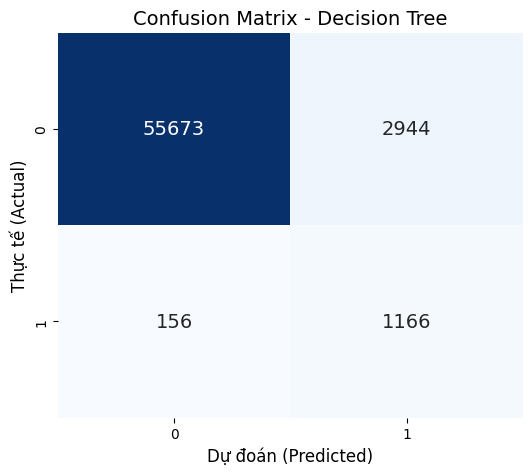


>>> MÔ HÌNH: Gaussian NB
Recall: 70.05% | F1-Score: 0.3923


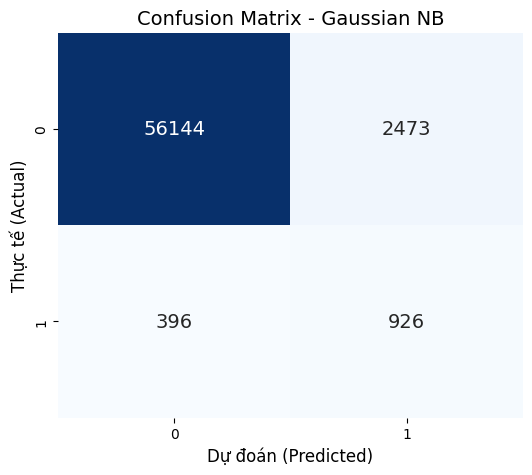


>>> MÔ HÌNH: Bernoulli NB
Recall: 58.32% | F1-Score: 0.2841


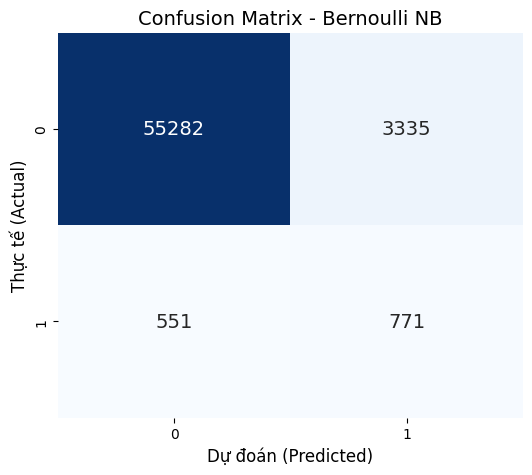


>>> MÔ HÌNH: Random Forest (Tuned)
Recall: 91.00% | F1-Score: 0.4785


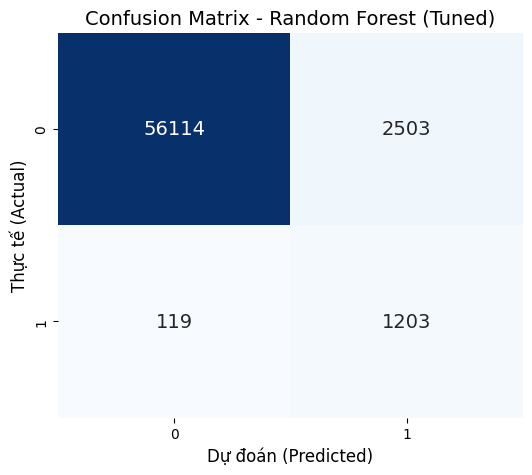


=============== SO SÁNH TỔNG QUÁT ===============


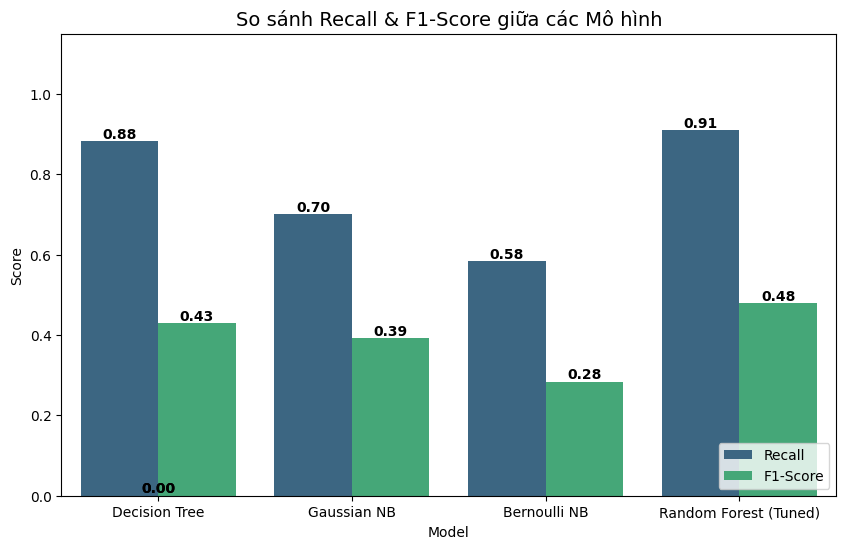

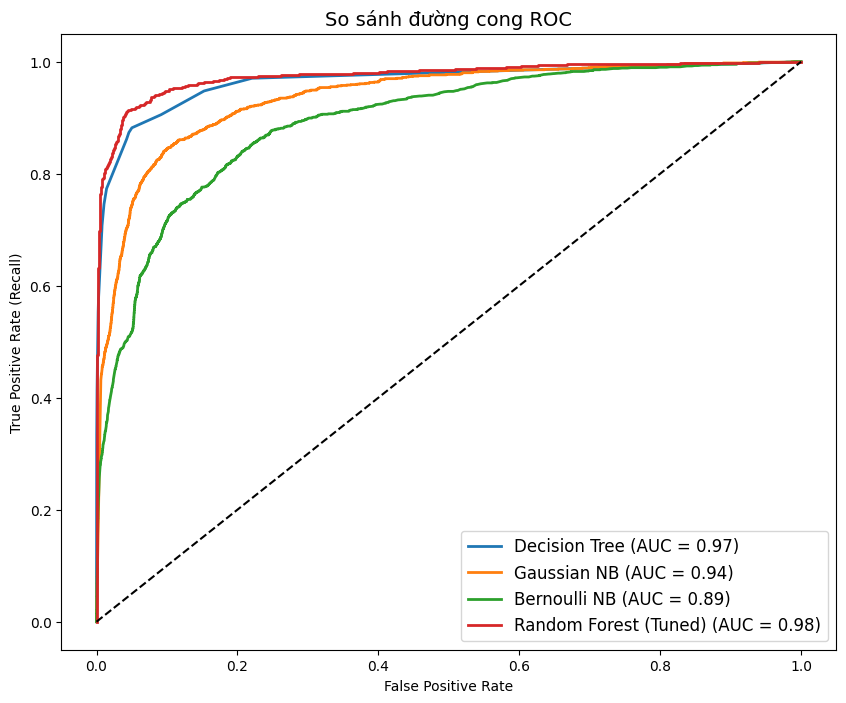

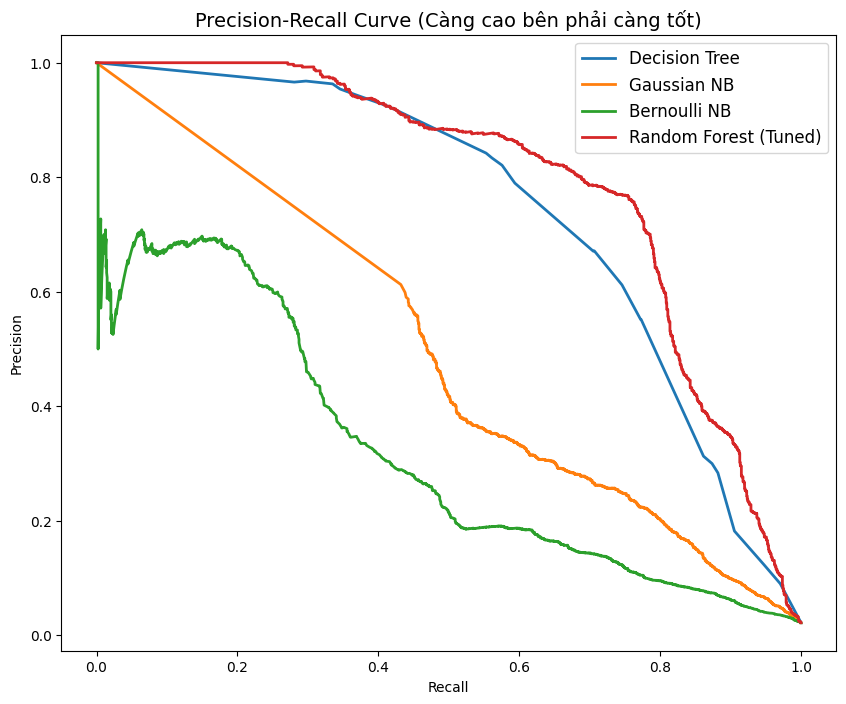


=============== PHÂN TÍCH GAUSSIAN NB ===============


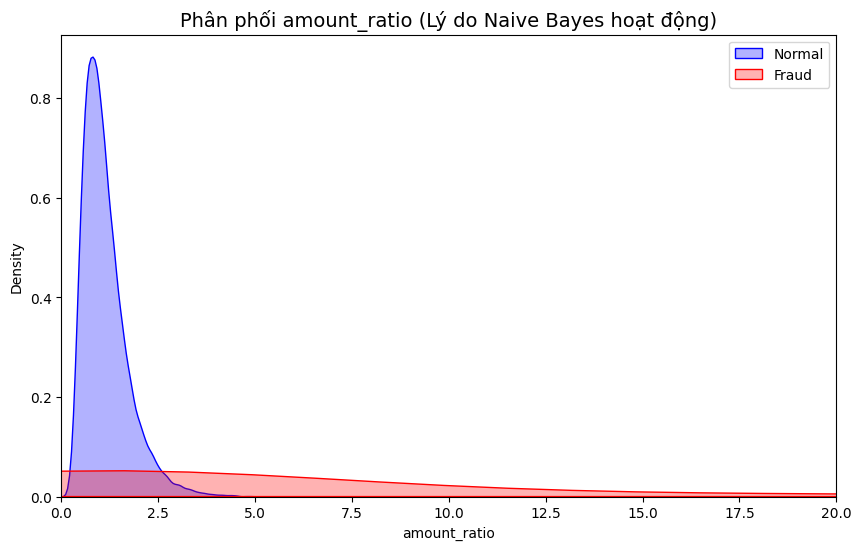


=============== CẤU TRÚC CÂY QUYẾT ĐỊNH ===============


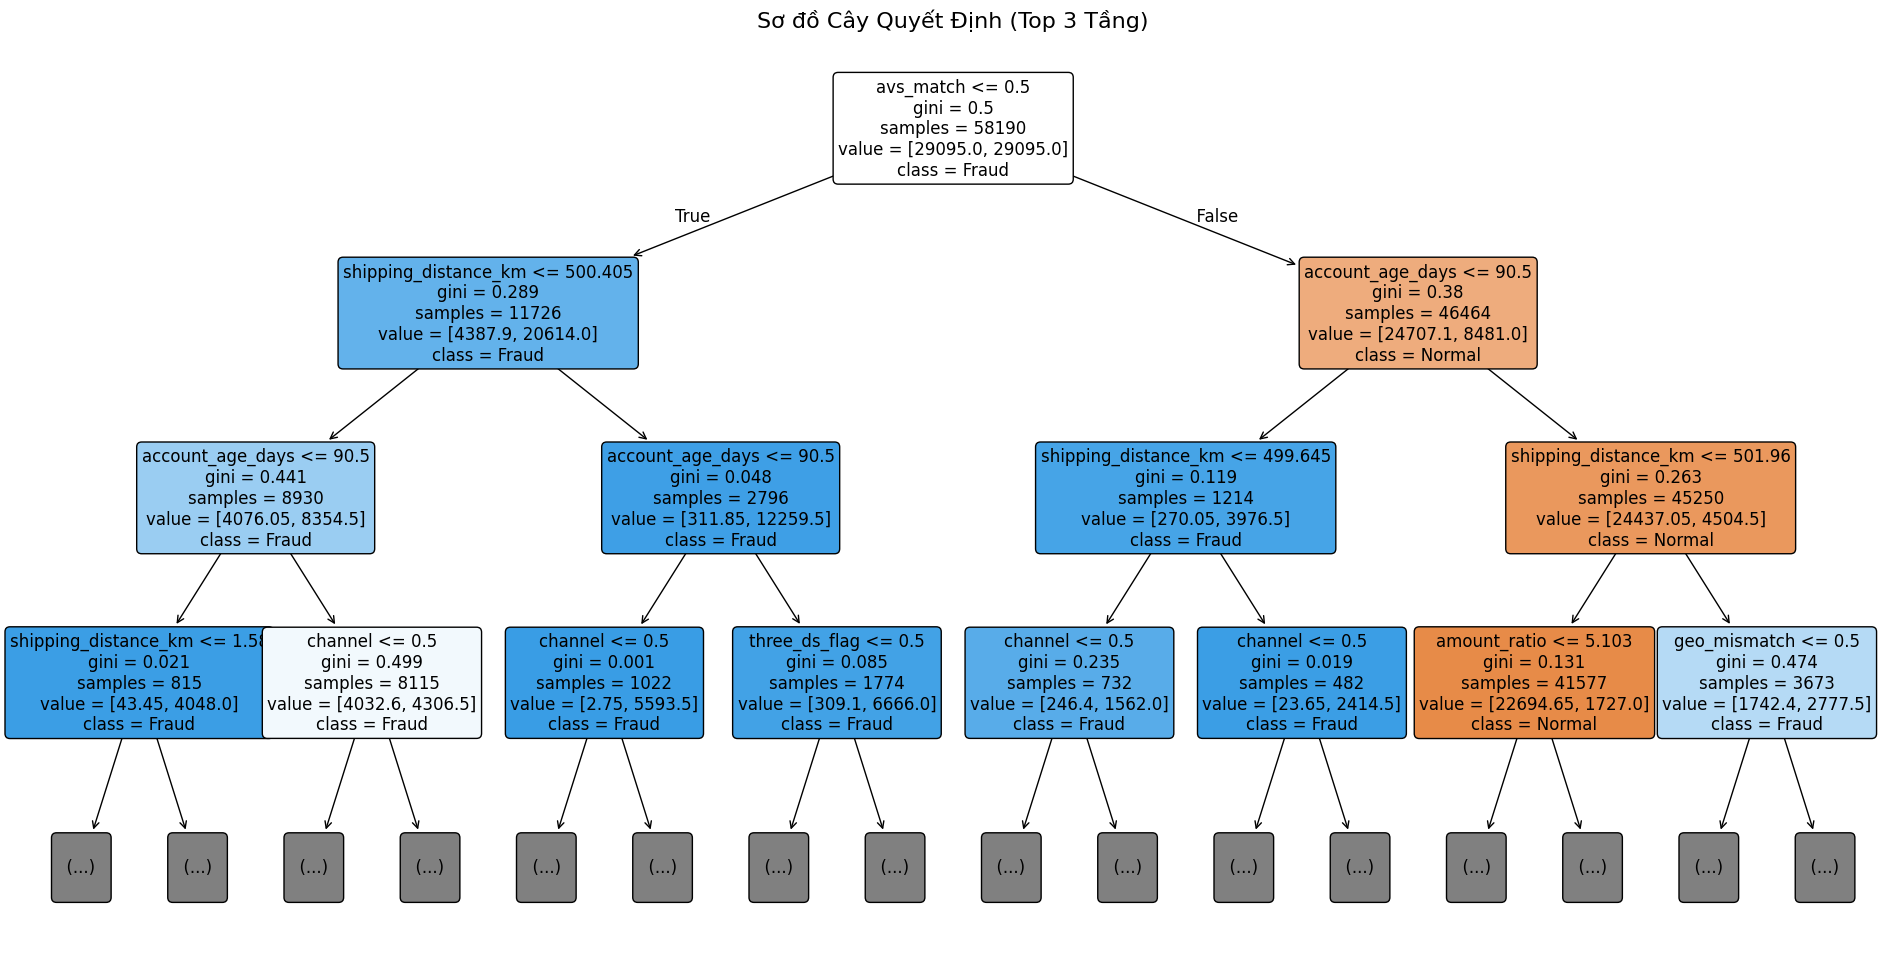


=============== ĐẶC TRƯNG QUAN TRỌNG NHẤT ===============


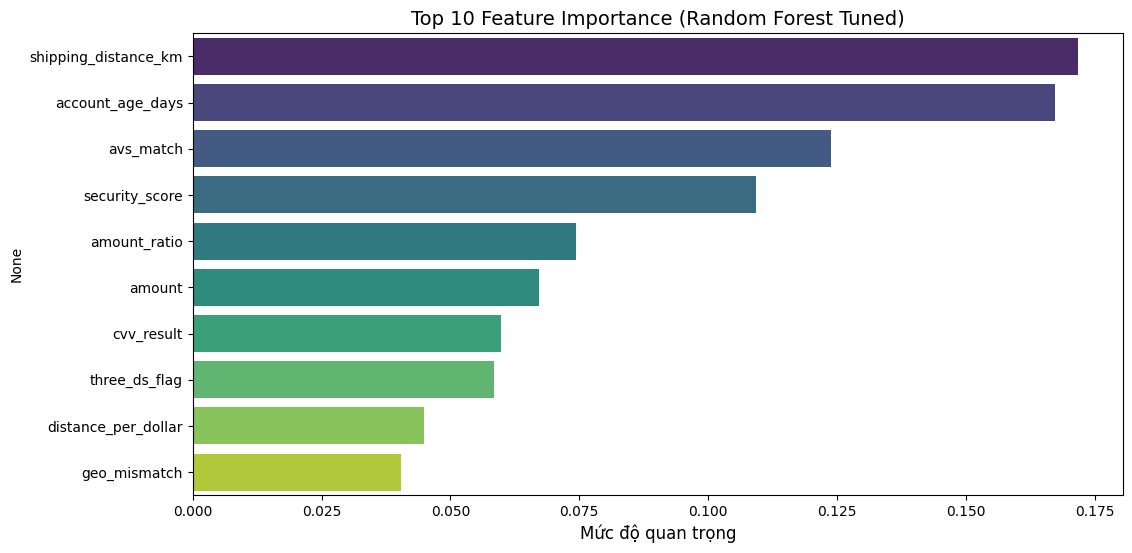

In [6]:
# MODULE 6 & 7: EVALUATION & VISUALIZATION

def evaluate_and_plot_separated(models_dict, X_test, y_test):
    results_df = []

    # PHẦN 1: ĐÁNH GIÁ CHI TIẾT & VẼ CONFUSION MATRIX RIÊNG
    print(f"{'='*15} CHI TIẾT TỪNG MÔ HÌNH {'='*15}")
    
    for name, model in models_dict.items():
        y_pred = model.predict(X_test)
        
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results_df.append({'Model': name, 'Recall': rec, 'F1-Score': f1})
        
        print(f"\n>>> MÔ HÌNH: {name}")
        print(f"Recall: {rec:.2%} | F1-Score: {f1:.4f}")
        
        # VẼ CONFUSION MATRIX
        plt.figure(figsize=(6, 5))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
        plt.title(f"Confusion Matrix - {name}", fontsize=14)
        plt.xlabel('Dự đoán (Predicted)', fontsize=12)
        plt.ylabel('Thực tế (Actual)', fontsize=12)
        plt.show()

    # PHẦN 2: BIỂU ĐỒ SO SÁNH HIỆU NĂNG
    print(f"\n{'='*15} SO SÁNH TỔNG QUÁT {'='*15}")
    res_frame = pd.DataFrame(results_df)
    res_melted = res_frame.melt(id_vars="Model", var_name="Metric", value_name="Score")
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=res_melted, x="Model", y="Score", hue="Metric", palette="viridis")
    plt.title("So sánh Recall & F1-Score giữa các Mô hình", fontsize=14)
    plt.ylim(0, 1.15)
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')
    plt.legend(loc='lower right')
    plt.show()

    # PHẦN 3: SO SÁNH ROC CURVE
    plt.figure(figsize=(10, 8))
    for name, model in models_dict.items():
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('So sánh đường cong ROC', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

    # PHẦN 4: PRECISION-RECALL CURVE
    plt.figure(figsize=(10, 8))
    for name, model in models_dict.items():
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
            from sklearn.metrics import precision_recall_curve
            precision, recall, _ = precision_recall_curve(y_test, y_prob)
            plt.plot(recall, precision, linewidth=2, label=name)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Càng cao bên phải càng tốt)', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

all_models = baselines.copy()
all_models["Random Forest (Tuned)"] = best_rf

evaluate_and_plot_separated(all_models, X_test, y_test)


# PHẦN 5: VISUALIZATION RIÊNG LẺ

# 5.1 Naive Bayes Distribution
print(f"\n{'='*15} PHÂN TÍCH GAUSSIAN NB {'='*15}")
feature_to_check = 'amount_ratio' 
plt.figure(figsize=(10, 6))
test_df_vis = X_test.copy()
test_df_vis['is_fraud'] = y_test.values
sns.kdeplot(data=test_df_vis[test_df_vis['is_fraud']==0], x=feature_to_check, fill=True, label='Normal', color='blue', alpha=0.3)
sns.kdeplot(data=test_df_vis[test_df_vis['is_fraud']==1], x=feature_to_check, fill=True, label='Fraud', color='red', alpha=0.3)
plt.title(f"Phân phối {feature_to_check} (Lý do Naive Bayes hoạt động)", fontsize=14)
plt.xlim(0, 20) 
plt.legend()
plt.show()

# 5.2 Decision Tree Visualization
print(f"\n{'='*15} CẤU TRÚC CÂY QUYẾT ĐỊNH {'='*15}")
plt.figure(figsize=(24, 12)) 
plot_tree(baselines['Decision Tree'], 
          feature_names=X_test.columns, 
          class_names=['Normal', 'Fraud'], 
          filled=True, rounded=True, max_depth=3, fontsize=12)
plt.title("Sơ đồ Cây Quyết Định (Top 3 Tầng)", fontsize=16)
plt.show()

# 5.3 Feature Importance (RF Tuned)
print(f"\n{'='*15} ĐẶC TRƯNG QUAN TRỌNG NHẤT {'='*15}")
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=X_test.columns[indices], palette="viridis")
plt.title("Top 10 Feature Importance (Random Forest Tuned)", fontsize=14)
plt.xlabel("Mức độ quan trọng", fontsize=12)
plt.show()